Cyna Shirazinejad, 3/2/22

# Notebook 8d: compare CCP lifetimes (all single DNM2 peak events) between DMSO and CK666 treatments


##### import all necessary Python modules

In [84]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import pickle
from IPython.display import Image
from scipy import signal
import scipy.stats as stats
import seaborn as sns

analysis_metadata = np.load('analysis_metadata.npy', allow_pickle=True)
sys.path.append(analysis_metadata.item().get('path_notebook')+'/cmeAnalysisPostProcessingSimplified') # add custom Python scripts to the local path
import separate_tracking_merge_tools
import merge_tools
import generate_index_dictionary
import return_track_attributes
index_dictionary = generate_index_dictionary.return_index_dictionary()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
analysis_metadata

array({'path_outputs': '/Volumes/GoogleDrive/My Drive/Drubin Lab/ap2dynm2arcp3_project/stable_outputs_20220211', 'path_notebook': '/Users/cynashirazinejad/Documents/GitHub/Jin_Shirazinejad_et_al_branched_actin_manuscript/analysis/simplified_workflow_20220211', 'feature_units': ['seconds', 'a.u. fluorescence', 'a.u. fluorescence', 'pixels', 'pixels', 'pixels', 'pixels', 'pixels', 'seconds', 'seconds', 'seconds', 'seconds', 'seconds', 'a.u. fluorescence', 'a.u. fluorescence', 'a.u. fluorescence', 'a.u. fluorescence', 'a.u. fluorescence', 'unitless', 'a.u. fluorescence', 'a.u. fluorescence', 'a.u. fluorescence**2', 'a.u. fluorescence**2', 'unitless', 'unitless', 'unitless', 'unitless', 'counts', 'counts', 'unitless', 'unitless', 'unitless'], 'possible_track_features': ['lifetime', 'max_int_ch0', 'max_int_ch1', 'dist_traveled_ch0', 'dist_traveled_ch1', 'max_dist_between_ch0-ch1', 'md_ch0', 'md_ch1', 'time_to_peak_ch0', 'time_to_peak_ch1', 'time_after_peak_ch0', 'time_after_peak_ch1', 'time

# load all valid arpc3 tracks

In [86]:
experiment = 'ada_ck666_dmso'

In [87]:
experiment_metadata = analysis_metadata.item().get('experiment_groups')[experiment]
num_tracks = experiment_metadata['number_of_track_splits']
name_tracks = experiment_metadata['tracks']
path_tracks_secondary = experiment_metadata['tracks_secondary']
name_secondary_structures = experiment_metadata['name_secondary_structures']
df_experiment = experiment_metadata['df']
path_outputs = analysis_metadata.item().get('path_outputs')
df_experiment = pd.read_csv(path_outputs+'/dataframes/'+df_experiment+'.zip')

# load all valid tracks ap2/dnm2 tracks from arpc3 line

In [88]:
merged_all_valid_tracks = np.load(path_outputs+
                              '/dataframes/'+
                              name_tracks+
                              '_0.npy', allow_pickle=True)
for i in range(1, num_tracks):
    print(i)
    merged_all_valid_tracks = np.concatenate((merged_all_valid_tracks,
                                             np.load(path_outputs+
                                             '/dataframes/'+
                                             name_tracks+
                                             '_'+
                                             str(i)+
                                             '.npy', allow_pickle=True)))

1
2
3
4
5
6
7
8


In [89]:
merged_all_valid_tracks.shape

(55964,)

# sort DNM2+ events

In [90]:
number_of_clusters = analysis_metadata.item().get('number_of_clusters')

num_gmm_clusters = number_of_clusters # optimal number of clusters of PCA data


gmm_classes = []

df = df_experiment

for i in range(num_gmm_clusters):

    gmm_classes.append(df[df['gmm_predictions']==i].index.values)    

In [91]:
index_dnm2positive = analysis_metadata.item().get('index_DNM2positive')

In [92]:
len(gmm_classes[index_dnm2positive])

5245

In [93]:
tracks_authentic_ccps_gmm = merged_all_valid_tracks[gmm_classes[index_dnm2positive]] #dnm2 positive events, mixed CCPS and hot-spots

In [94]:
len(tracks_authentic_ccps_gmm)

5245

# separate single-CCP events by experiment

In [95]:
len(np.where(df['ccp_status']==1)[0])

1994

In [96]:
experiment_numbers = list(np.sort(list(set(df_experiment['experiment_number']))))

In [97]:
experiment_numbers = [int(exp) for exp in experiment_numbers]

In [98]:
experiment_numbers

[34, 35, 36, 40, 41, 42, 52, 53, 54]

In [99]:
sos = signal.butter(4, 0.2, 'lp', fs=1, output='sos')
distance_best_fit = analysis_metadata.item().get('distance_best_fit')
height_best_fit = analysis_metadata.item().get('height_best_fit')
width_best_fit = analysis_metadata.item().get('width_best_fit')

In [100]:
merged_all_valid_tracks_per_experiment = [] # each entry is a list for each experiment of tracks corresponding to predicted ccps 

ccp_events_per_experiment = []

for experiment_number in experiment_numbers: # only look at 3-color movies
    print(experiment_number)
    tracks_exp_idx = df[df['experiment_number']==experiment_number].index.values
    tracks_exp = merged_all_valid_tracks[tracks_exp_idx]
    
    ccp_preds_exp = df['ccp_status'].values[tracks_exp_idx]
    idx_ccp_exp = np.where(ccp_preds_exp==1)[0]
    
    ccp_events_per_experiment.append(tracks_exp[idx_ccp_exp])

34
35
36
40
41
42
52
53
54


In [101]:
merged_ccps = merge_tools.merge_experiments(ccp_events_per_experiment, [list(range(len(track_set))) for track_set in ccp_events_per_experiment])

In [102]:
len(merged_ccps)

1994

In [103]:
ccp_lifetime_dmso= []
ap2_lifetime_dmso = []
for i in range((len(merged_ccps))):
               
        raw_intensity = return_track_attributes.return_track_amplitude_no_buffer_channel(merged_ccps,i,1)

        # add zeros to end to account for phase shift of near-track-end peaks
        filtered_amplitude = list(list(signal.sosfilt(sos, raw_intensity)) + [0, 0, 0, 0, 0])

        dnm2_peak = signal.find_peaks(filtered_amplitude, 
                              distance=distance_best_fit, 
                              height=height_best_fit,
                              width=width_best_fit)[0][0]
        
        ccp_lifetime_dmso.append(dnm2_peak)
        ap2_lifetime_dmso.append(len(filtered_amplitude))

# load all valid arpc3 tracks

In [104]:
experiment = 'ada_ck666_ck666'

In [105]:
experiment_metadata = analysis_metadata.item().get('experiment_groups')[experiment]
num_tracks = experiment_metadata['number_of_track_splits']
name_tracks = experiment_metadata['tracks']
path_tracks_secondary = experiment_metadata['tracks_secondary']
name_secondary_structures = experiment_metadata['name_secondary_structures']
df_experiment = experiment_metadata['df']
path_outputs = analysis_metadata.item().get('path_outputs')
df_experiment = pd.read_csv(path_outputs+'/dataframes/'+df_experiment+'.zip')

# load all valid tracks ap2/dnm2 tracks from arpc3 line

In [106]:
merged_all_valid_tracks = np.load(path_outputs+
                              '/dataframes/'+
                              name_tracks+
                              '_0.npy', allow_pickle=True)
for i in range(1, num_tracks):
    print(i)
    merged_all_valid_tracks = np.concatenate((merged_all_valid_tracks,
                                             np.load(path_outputs+
                                             '/dataframes/'+
                                             name_tracks+
                                             '_'+
                                             str(i)+
                                             '.npy', allow_pickle=True)))

1
2
3
4
5
6
7
8


In [107]:
merged_all_valid_tracks.shape

(52684,)

# sort DNM2+ events

In [108]:
number_of_clusters = analysis_metadata.item().get('number_of_clusters')

num_gmm_clusters = number_of_clusters # optimal number of clusters of PCA data


gmm_classes = []

df = df_experiment

for i in range(num_gmm_clusters):

    gmm_classes.append(df[df['gmm_predictions']==i].index.values)    

In [109]:
index_dnm2positive = analysis_metadata.item().get('index_DNM2positive')

In [110]:
len(gmm_classes[index_dnm2positive])

4249

In [111]:
tracks_authentic_ccps_gmm = merged_all_valid_tracks[gmm_classes[index_dnm2positive]] #dnm2 positive events, mixed CCPS and hot-spots

In [112]:
len(tracks_authentic_ccps_gmm)

4249

# separate single-CCP events by experiment

In [113]:
len(np.where(df['ccp_status']==1)[0])

1362

In [114]:
experiment_numbers = list(np.sort(list(set(df_experiment['experiment_number']))))

In [115]:
experiment_numbers = [int(exp) for exp in experiment_numbers]

In [116]:
experiment_numbers

[31, 32, 33, 37, 38, 39, 49, 50, 51]

In [117]:
sos = signal.butter(4, 0.2, 'lp', fs=1, output='sos')
distance_best_fit = analysis_metadata.item().get('distance_best_fit')
height_best_fit = analysis_metadata.item().get('height_best_fit')
width_best_fit = analysis_metadata.item().get('width_best_fit')

In [118]:
merged_all_valid_tracks_per_experiment = [] # each entry is a list for each experiment of tracks corresponding to predicted ccps 

ccp_events_per_experiment = []

for experiment_number in experiment_numbers: # only look at 3-color movies
    print(experiment_number)
    tracks_exp_idx = df[df['experiment_number']==experiment_number].index.values
    tracks_exp = merged_all_valid_tracks[tracks_exp_idx]
    
    ccp_preds_exp = df['ccp_status'].values[tracks_exp_idx]
    idx_ccp_exp = np.where(ccp_preds_exp==1)[0]
    
    ccp_events_per_experiment.append(tracks_exp[idx_ccp_exp])

31
32
33
37
38
39
49
50
51


In [119]:
merged_ccps = merge_tools.merge_experiments(ccp_events_per_experiment, [list(range(len(track_set))) for track_set in ccp_events_per_experiment])

In [120]:
len(merged_ccps)

1362

In [121]:
ccp_lifetime_ck666= []
ap_lifetime_ck666 = []
for i in range((len(merged_ccps))):
               
        raw_intensity = return_track_attributes.return_track_amplitude_no_buffer_channel(merged_ccps,i,1)

        # add zeros to end to account for phase shift of near-track-end peaks
        filtered_amplitude = list(list(signal.sosfilt(sos, raw_intensity)) + [0, 0, 0, 0, 0])

        dnm2_peak = signal.find_peaks(filtered_amplitude, 
                              distance=distance_best_fit, 
                              height=height_best_fit,
                              width=width_best_fit)[0][0]
        
        ccp_lifetime_ck666.append(dnm2_peak)
        ap_lifetime_ck666.append(len(filtered_amplitude))

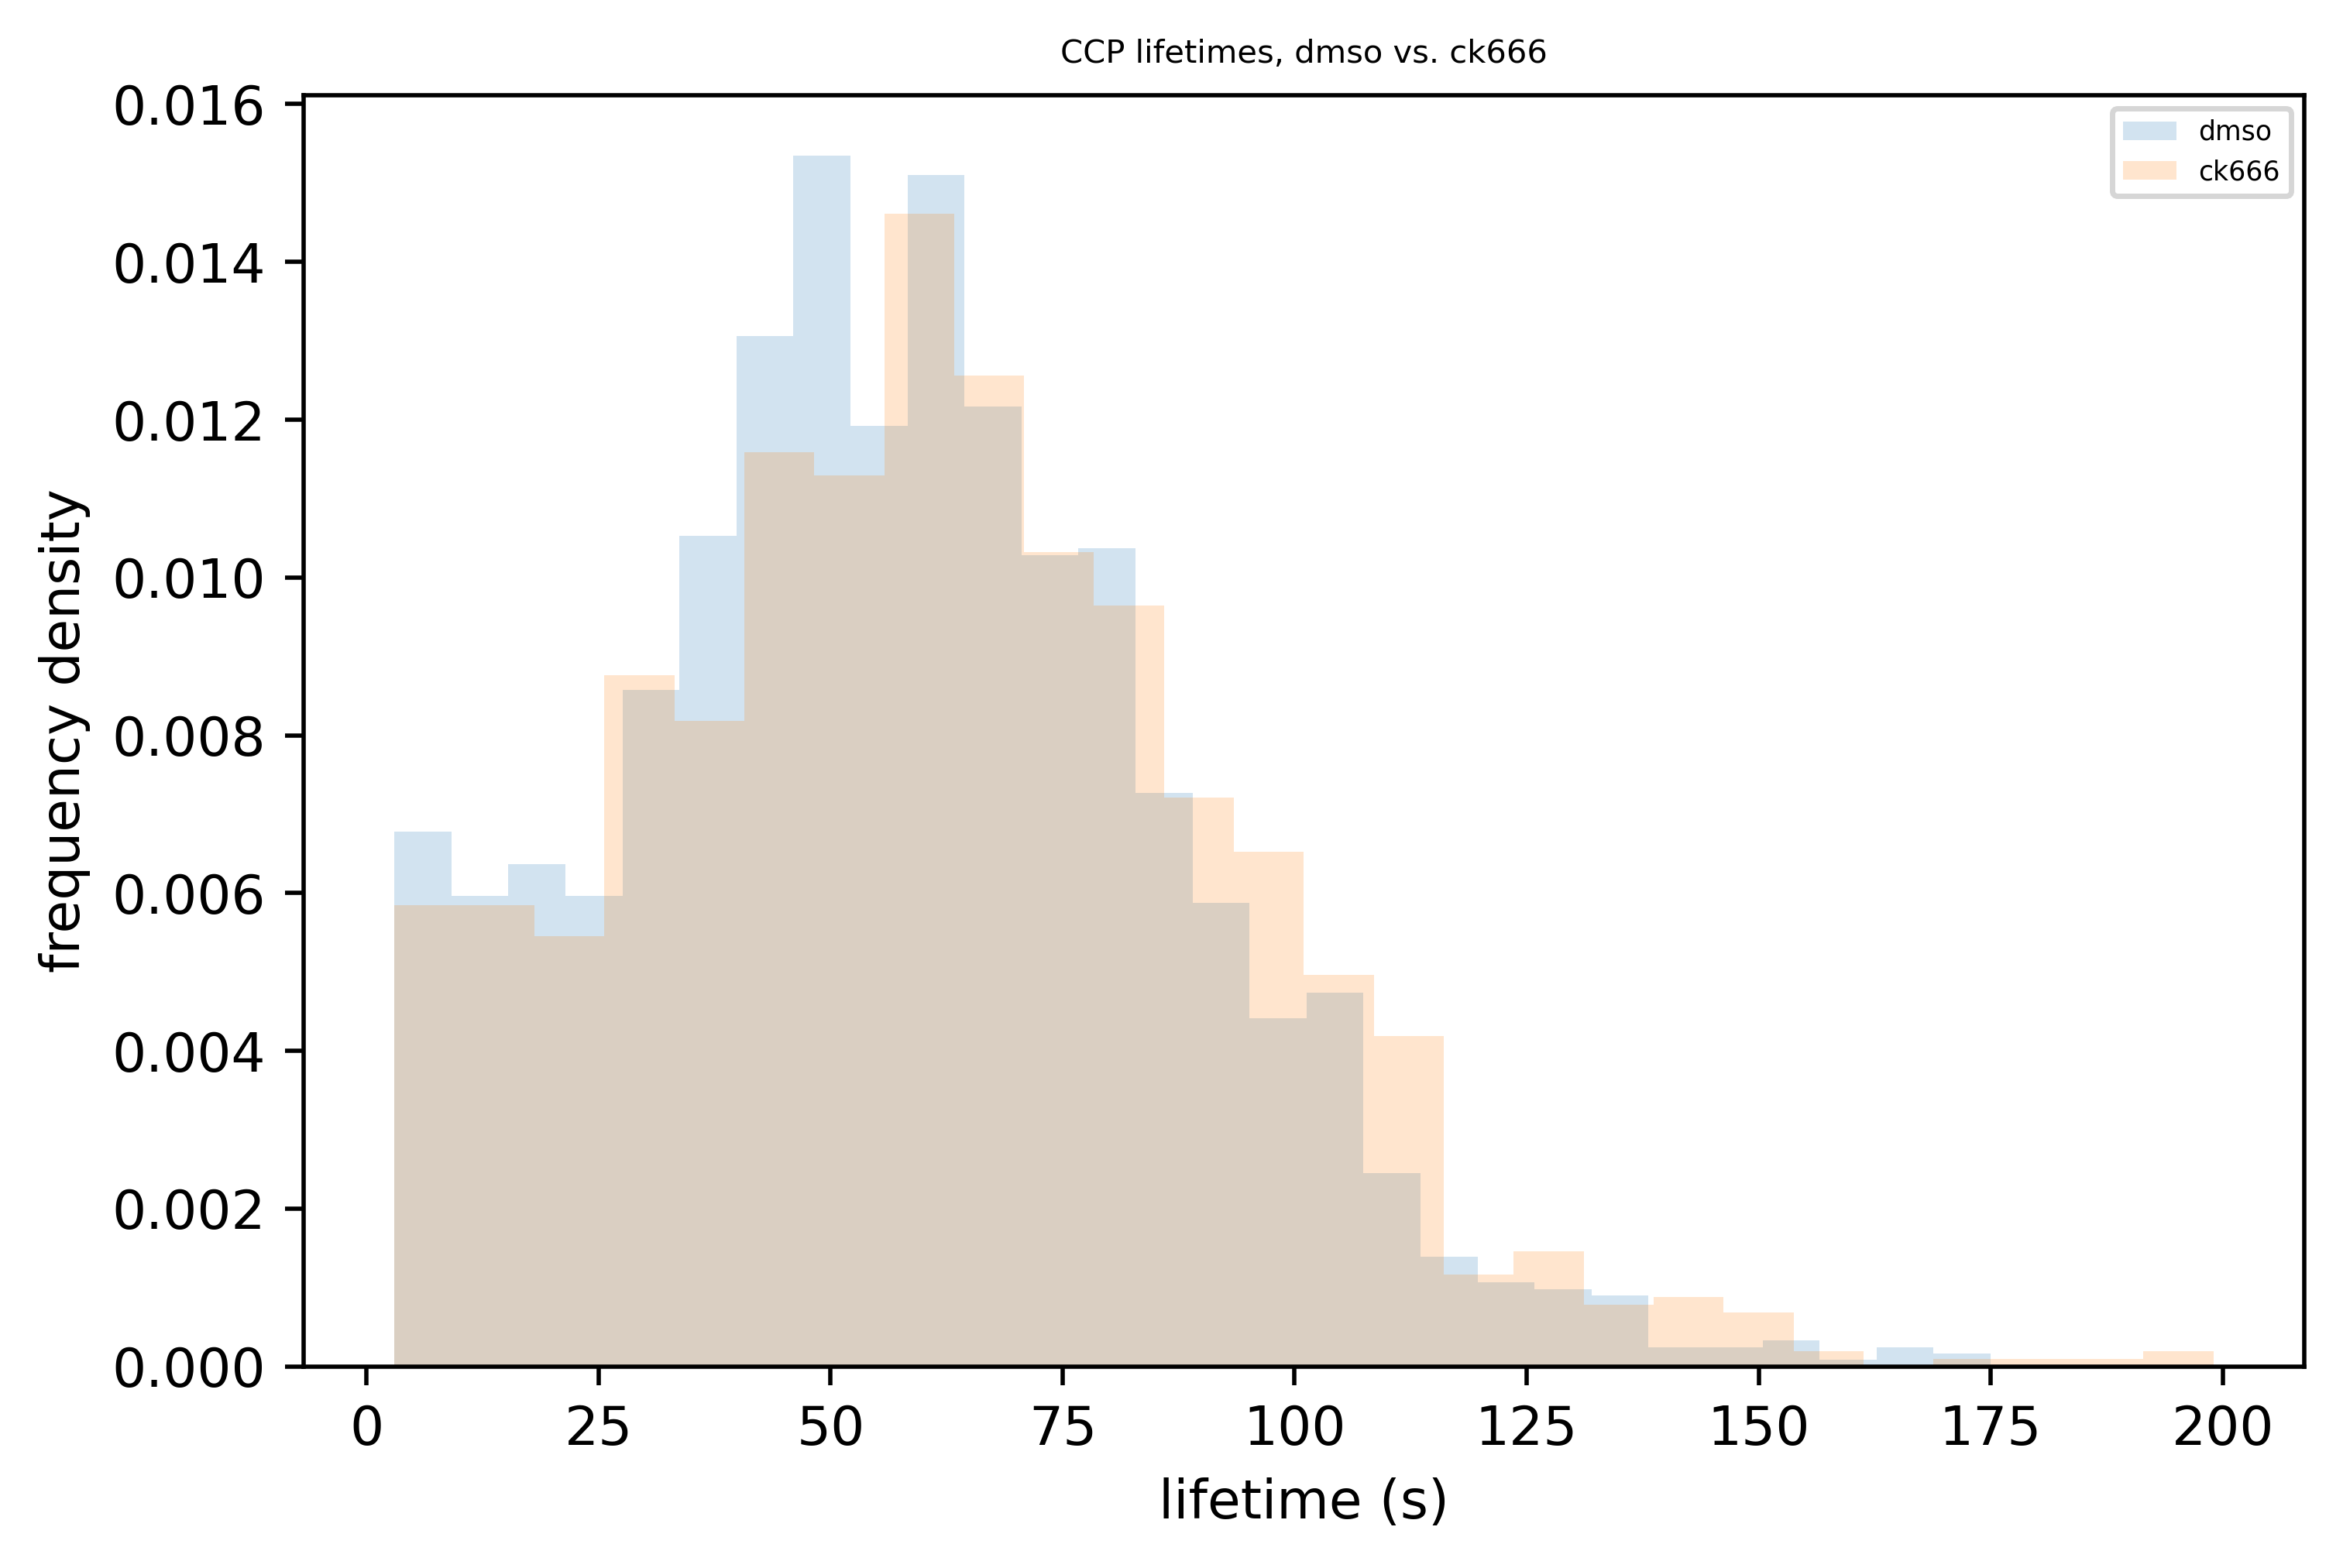

In [122]:
plt.rcParams['figure.dpi']=500
plt.rcParams['figure.figsize']=(6,4)
plt.hist(ccp_lifetime_dmso, alpha=0.2, label='dmso', bins='auto', density=True)
plt.hist(ccp_lifetime_ck666, alpha=0.2, label='ck666', bins='auto', density=True)
plt.rcParams.update({'font.size': 5})
plt.xlabel('lifetime (s)')
plt.ylabel('frequency density')
plt.title('CCP lifetimes, dmso vs. ck666')
plt.legend()
plt.tight_layout()

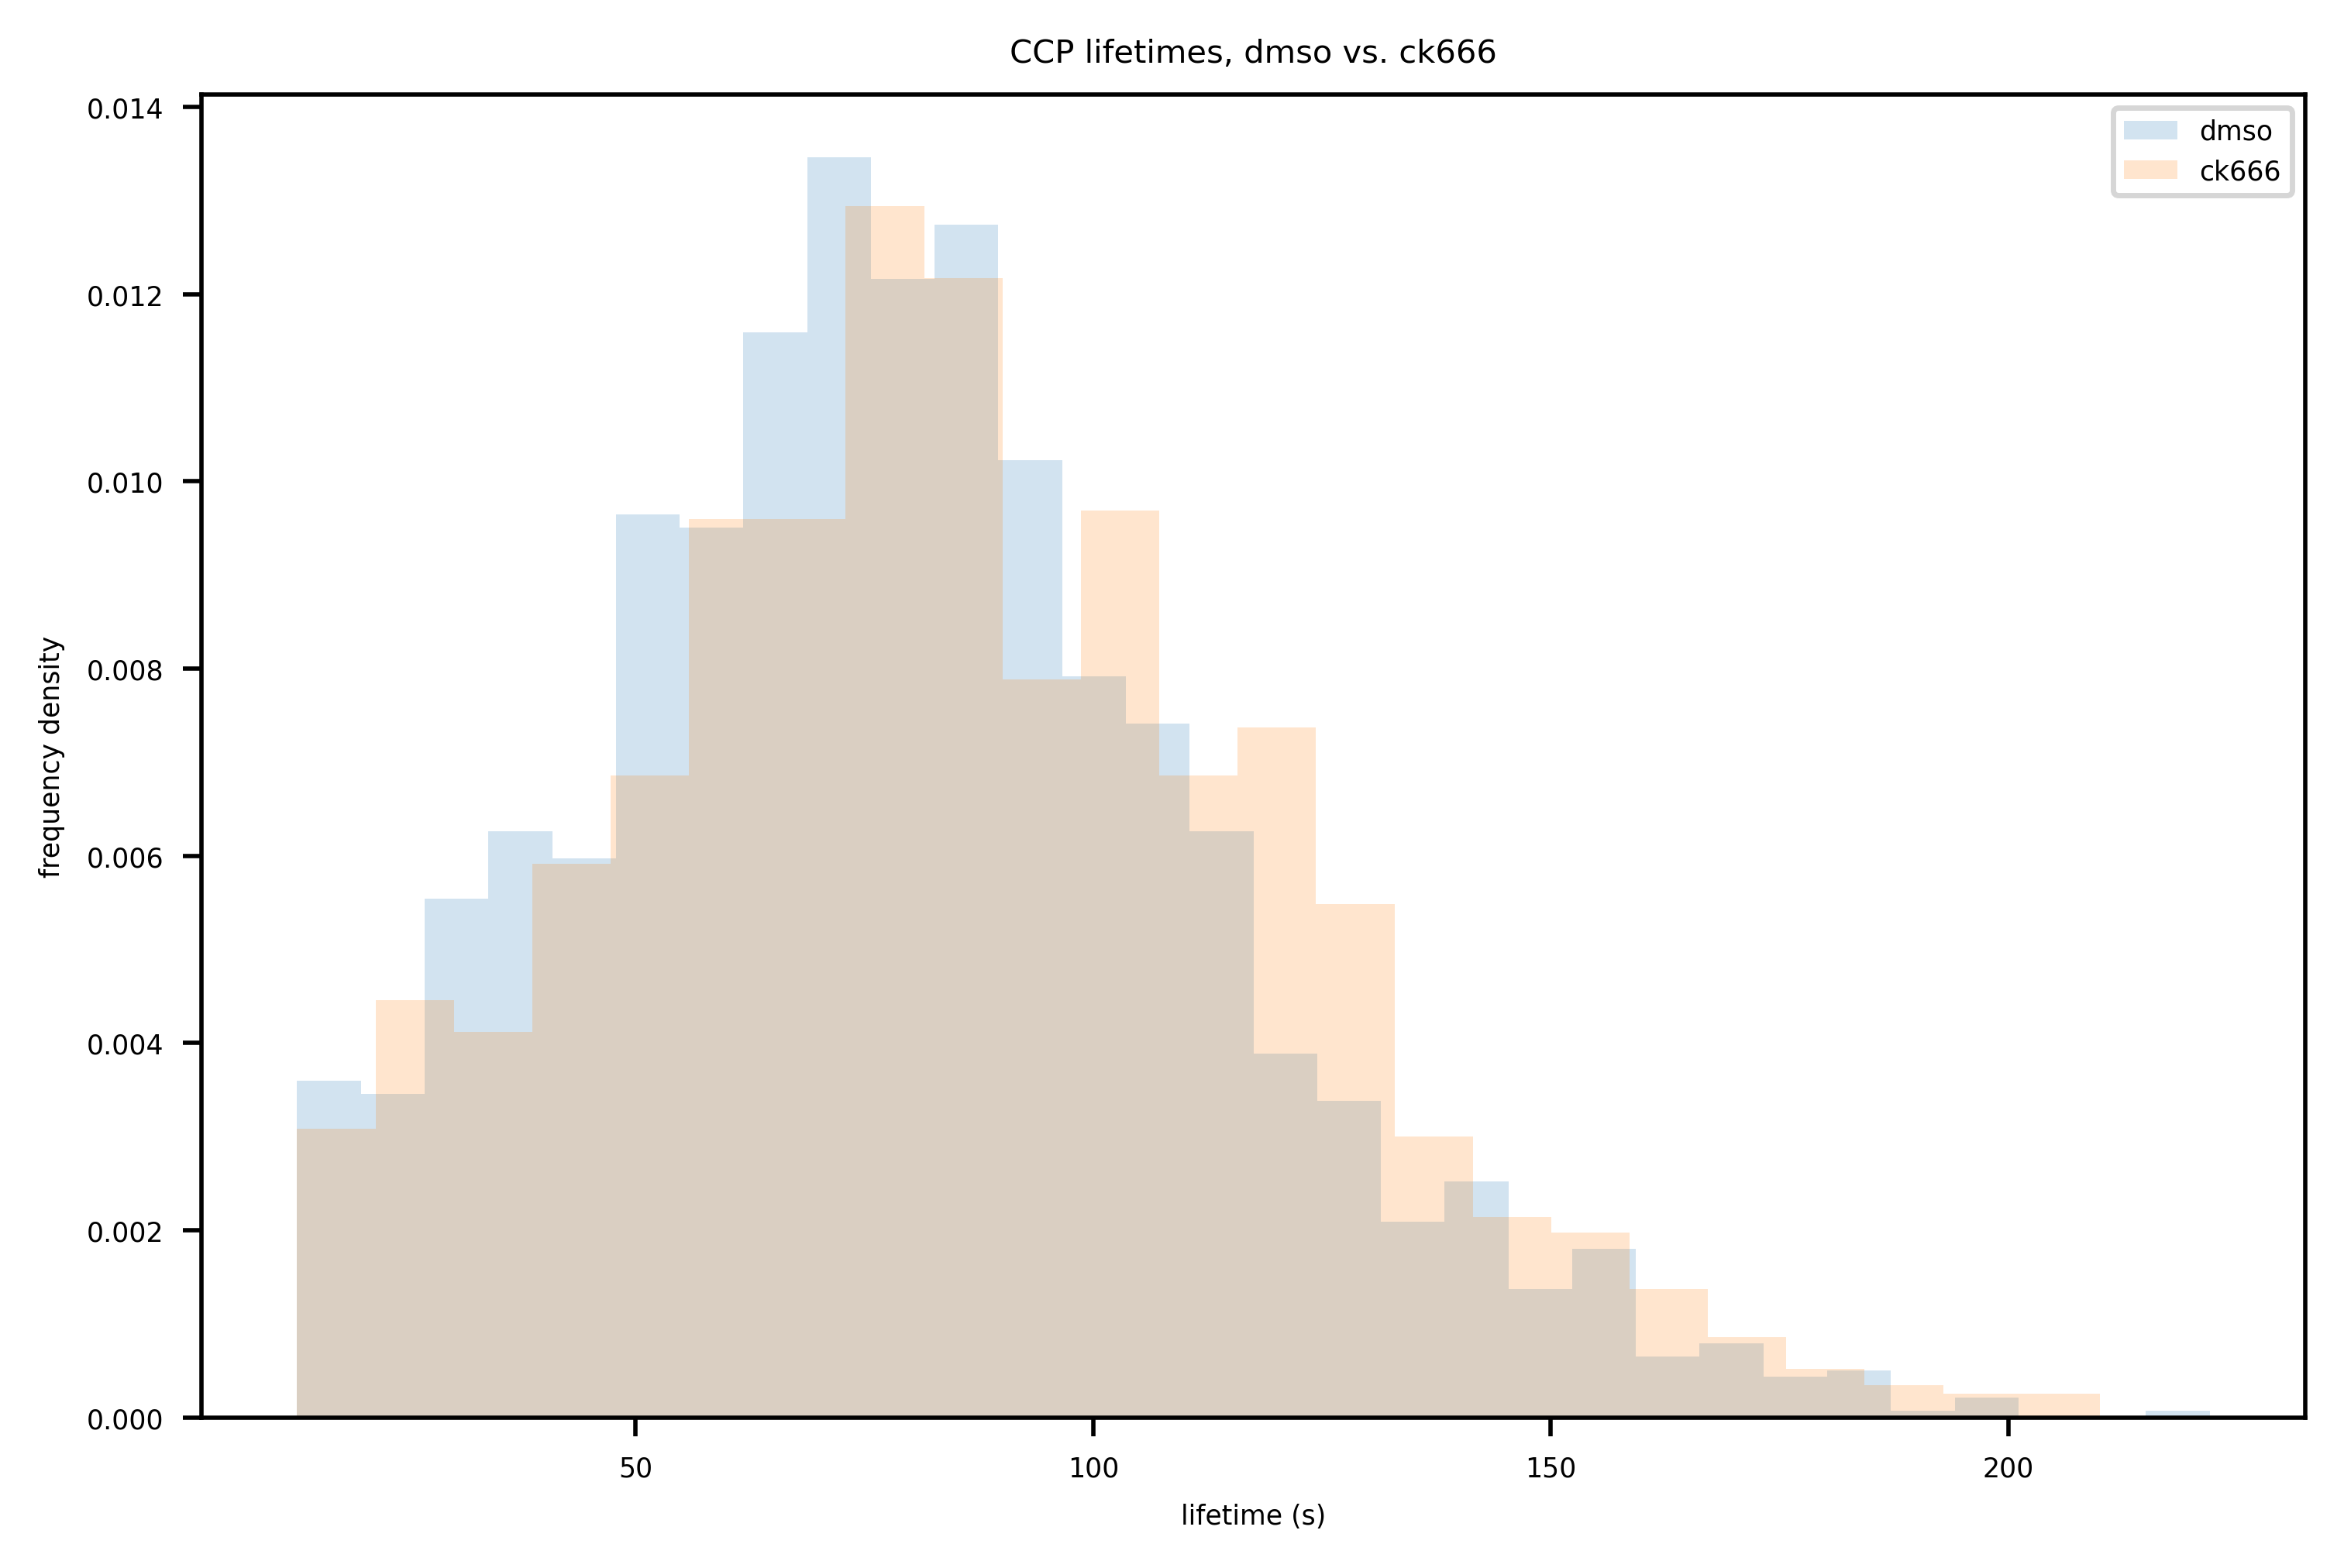

In [124]:
plt.rcParams['figure.dpi']=500
plt.rcParams['figure.figsize']=(6,4)
plt.hist(ap2_lifetime_dmso, alpha=0.2, label='dmso', bins='auto', density=True)
plt.hist(ap_lifetime_ck666, alpha=0.2, label='ck666', bins='auto', density=True)
plt.rcParams.update({'font.size': 5})
plt.xlabel('lifetime (s)')
plt.ylabel('frequency density')
plt.title('CCP lifetimes, dmso vs. ck666')
plt.legend()
plt.tight_layout()
# plt.savefig(unique_user_saved_outputs+'/plots/fig_4a_ccplifetimes_plusminus_arpc3_histogram_density_sigdnm2peak_zeropadding.png')